## Load Data

In [1]:
# Load Train and Test data
import os
import torch
import numpy as np

datadir = "/home/ucaptp0/oasis-rt-surrogate/data/preprocessed_data/rnn_sw/dynamical"

train_x = torch.load(os.path.join(datadir, "train_x.pt"))
train_y = torch.load(os.path.join(datadir, "train_y.pt"))
test_x = torch.load(os.path.join(datadir, "test_x.pt"))
test_y = torch.load(os.path.join(datadir, "test_y.pt"))

test_cosz = torch.load(os.path.join(datadir, "test_cosz.pt"))
test_cosz = test_cosz.numpy()
train_cosz = torch.load(os.path.join(datadir, "train_cosz.pt"))
train_cosz = train_cosz.numpy()

train_x = train_x.numpy()
train_y = train_y.numpy()
test_x = test_x.numpy()
test_y = test_y.numpy()

In [2]:
train_aux_x = torch.load(os.path.join(datadir, "train_aux_x.pt"))
test_aux_x = torch.load(os.path.join(datadir, "test_aux_x.pt"))

## Extreme Learning Machine

In the `fit` method, $X$ is the training data matrix with dimensions $N \times d$, where:
- $N$ is the number of training samples.
- $d$ is the number of features (input dimensionality).

For the `fit` method in the provided `ELM` class, the input parameters are:
- `X`: A numpy array of shape $(N, d)$, representing the training data.
- `T`: A numpy array of shape $(N, m)$, representing the target outputs, where $m$ is the output dimensionality.

Here's a breakdown of the dimensions involved in the `fit` method:

1. **Input Data $X$:** 
   $$
   X \in \mathbb{R}^{N \times d}
   $$

2. **Hidden Layer Weights $\mathbf{W}$:**
   $$
   \mathbf{W} \in \mathbb{R}^{L \times d}
   $$
   where $L$ is the number of hidden neurons.

3. **Biases $\mathbf{b}$:**
   $$
   \mathbf{b} \in \mathbb{R}^{L}
   $$

4. **Hidden Layer Output Matrix $H$:**
   $$
   H = g(X \mathbf{W}^T + \mathbf{b}) \Rightarrow H \in \mathbb{R}^{N \times L}
   $$
   Here, each row of $X \mathbf{W}^T$ is a vector of size $L$, and the bias $\mathbf{b}$ is broadcasted to each row before applying the activation function $g$.

5. **Target Output Matrix $T$:**
   $$
   T \in \mathbb{R}^{N \times m}
   $$

6. **Output Weights $\mathbf{\beta}$:**
   $$
   \mathbf{\beta} = H^\dagger T \Rightarrow \mathbf{\beta} \in \mathbb{R}^{L \times m}
   $$
   where $H^\dagger$ is the Moore-Penrose pseudo-inverse of $H$.

In summary:
- $X$ should have dimensions $(N, d)$, where $N$ is the number of training samples and $d$ is the number of input features.
- $T$ should have dimensions $(N, m)$, where $m$ is the number of output dimensions.

In [3]:
import numpy as np
from scipy.linalg import pinv

class ELM:
    def __init__(self, input_size, hidden_size, output_size, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Randomly initialize input weights and biases
        self.W = np.random.randn(hidden_size, input_size)
        self.b = np.random.randn(hidden_size)
        
        if activation_function == 'sigmoid':
            self.activation_function = self._sigmoid
        elif activation_function == 'relu':
            self.activation_function = self._relu
        else:
            raise ValueError("Unsupported activation function.")
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def fit(self, X, T):
        # Calculate hidden layer output matrix H
        H = self.activation_function(np.dot(X, self.W.T) + self.b)
        
        # Calculate output weights beta
        self.beta = np.dot(pinv(H), T)
    
    def predict(self, X):
        # Calculate hidden layer output matrix for new data
        H_new = self.activation_function(np.dot(X, self.W.T) + self.b)
        
        # Calculate and return predictions
        return np.dot(H_new, self.beta)

In [13]:
import time

print("train_x shape: ", train_x.shape)

num_train_samples = 10000

X = train_x[:num_train_samples, :, :].reshape(num_train_samples, 49 * 3)
y = train_y[:num_train_samples, :, :].reshape(num_train_samples, 50 * 2)

input_size = 49 * 3
output_size = 50 * 2

hidden_size = 200

elm = ELM(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    activation_function="relu"
)


training_start_time = time.time()
elm.fit(X, y)
training_end_time = time.time()

print(f"Training time: {np.round(training_end_time - training_start_time, 2)} s")

train_x shape:  (3584000, 49, 3)
Training time: 0.14 s


In [10]:
import time

num_test_samples = 768000

Xtest = test_x[:, :, :].reshape(768000, 49 * 3)
ytest = test_y[:, :, :]

prediction_start_time = time.time()
ypred = elm.predict(Xtest)
prediction_end_time = time.time()
print(f"Prediction time for {ypred.shape[0]} samples: {np.round(prediction_end_time - prediction_start_time, 2)} s")
ypred = ypred.reshape(768000, 50, 2)

Prediction time for 768000 samples: 4.59 s


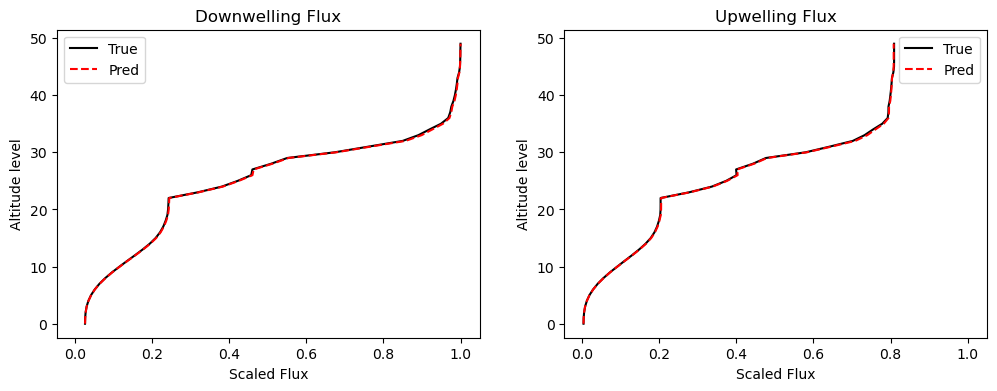

In [11]:
import matplotlib.pyplot as plt

sample = 5082

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)

axs[0].plot(ytest[sample, :, 0], list(range(50)), color="k", label="True")
axs[0].plot(ypred[sample, :, 0], list(range(50)), color="r", linestyle="--", label="Pred")
axs[0].set_title("Downwelling Flux")
axs[0].set_ylabel("Altitude level")
axs[0].set_xlabel("Scaled Flux")
axs[0].legend()

axs[1].plot(ytest[sample, :, 1], list(range(50)), color="k", label="True")
axs[1].plot(ypred[sample, :, 1], list(range(50)), color="r", linestyle="--", label="Pred")
axs[1].set_title("Upwelling Flux")
axs[1].set_ylabel("Altitude level")
axs[1].set_xlabel("Scaled Flux")
axs[1].legend()

plt.show()

In [148]:
# Save trained ELM

# params_dict = {
#     "W" : elm.W,
#     "b" : elm.b,
#     "beta" : elm.beta
# }
# import pickle
# with open("/home/ucaptp0/oasis-rt-surrogate/elm-params.ipynb", "wb") as f:
#     pickle.dump(params_dict, f)

# with open("/home/ucaptp0/oasis-rt-surrogate/elm-params.ipynb", "rb") as f:
#     tmp = pickle.load(f)
# print(tmp.keys())

dict_keys(['W', 'b', 'beta'])


In [150]:
for key in tmp.keys():
    print(key, params_dict[key].shape)

W (200, 147)
b (200,)
beta (200, 100)


## Echo State Network

In [ ]:
import numpy as np
from scipy.linalg import pinv

class ELM:
    def __init__(self, input_dim, hidden_dim, output_dim, activation_function='sigmoid'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Randomly initialize input weights and biases
        self.W = np.random.randn(hidden_dim, input_dim)
        self.b = np.random.randn(hidden_dim)
        
        if activation_function == 'sigmoid':
            self.activation_function = self._sigmoid
        elif activation_function == 'relu':
            self.activation_function = self._relu
        else:
            raise ValueError("Unsupported activation function.")
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def fit(self, X, T):
        # Calculate hidden layer output matrix H
        H = self.activation_function(np.dot(X, self.W.T) + self.b)
        
        # Calculate output weights beta
        self.beta = np.dot(pinv(H), T)
    
    def predict(self, X):
        # Calculate hidden layer output matrix for new data
        H_new = self.activation_function(np.dot(X, self.W.T) + self.b)
        
        # Calculate and return predictions
        return np.dot(H_new, self.beta)

In [ ]:
class RNN:
    def __init__(self, input_dim, hidden_dim, output_dim, activation_function='sigmoid'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Initialize weights
        self.Wx = np.random.randn(hidden_dim, input_dim)
        self.Wh = np.random.randn(hidden_dim, hidden_dim)
        self.Wy = np.random.randn(output_dim, hidden_dim)
        self.bh = np.random.randn((hidden_dim, 1))
        self.by = np.random.randn((output_dim, 1))

        if activation_function == 'sigmoid':
            self.activation_function = self._sigmoid
        elif activation_function == 'relu':
            self.activation_function = self._relu
        else:
            raise ValueError("Unsupported activation function.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _relu(self, x):
        return np.maximum(0, x)

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def forward(self, x, h_prev):
        h_next = self.activation_function(np.dot(self.Wx, x) + np.dot(self.Wh, h_prev) + self.bh)
        y = np.dot(self.Wy, h_next) + self.by
        return h_next, y

    def predict(self, X):
        T = X.shape[0]
        batch_size = X.shape[1]
        
        h = np.zeros((self.hidden_dim, batch_size))
        predictions = np.zeros((T, batch_size), dtype=int)
        
        for t in range(T):
            h, y = self.forward(X[t], h)
            y = self._softmax(y)
            predictions[t] = np.argmax(y, axis=0)
        
        return predictions


In [24]:
import numpy as np
from scipy.linalg import pinv

class EchoStateNetwork:
    def __init__(self, input_dim, reservoir_size, output_dim, spectral_radius=0.95, sparsity=0.1, input_scaling=1.0):
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.input_scaling = input_scaling
        
        # Initialize weights
        self.Win = np.random.randn(reservoir_size, input_dim) * input_scaling
        self.W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        self.W[np.random.rand(reservoir_size, reservoir_size) > sparsity] = 0
        
        # Scale W to ensure the echo state property
        radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / radius
        
        self.Wout = None
    
    def _update_state(self, x, prev_state):
        return np.tanh(np.dot(self.Win, x) + np.dot(self.W, prev_state))
    
    def fit(self, X, Y, washout=50):
        N = X.shape[1]  # number of samples
        state = np.zeros((self.reservoir_size, 1))
        states = np.zeros((self.reservoir_size, N))
        
        # Drive the reservoir with the input
        for t in range(N):
            state = self._update_state(X[:, t].reshape(-1, 1), state)
            if t >= washout:
                states[:, t - washout] = state.ravel()
        
        # Train the readout using pseudo-inverse
        states = states[:, washout:]
        Y = Y[:, washout:]
        self.Wout = np.dot(Y, pinv(states))
    
    def predict(self, X, washout=50):
        N = X.shape[1]
        state = np.zeros((self.reservoir_size, 1))
        outputs = np.zeros((self.output_dim, N - washout))
        
        for t in range(N):
            state = self._update_state(X[:, t].reshape(-1, 1), state)
            if t >= washout:
                outputs[:, t - washout] = np.dot(self.Wout, state).ravel()
        
        return outputs

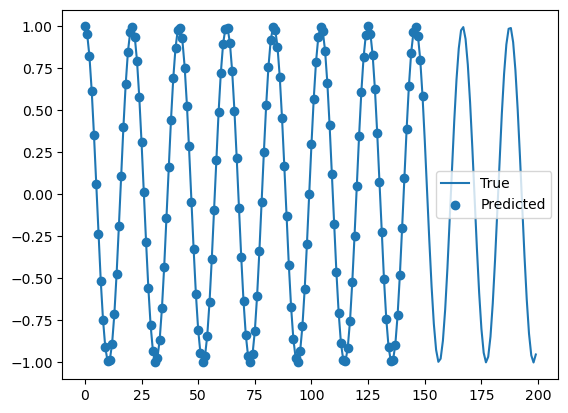

In [47]:
# Example usage
np.random.seed(42)

# Parameters
input_dim = 3
reservoir_size = 200
output_dim = 3
seq_length = 200

X_train = np.zeros(shape=(input_dim, seq_length))
Y_train = np.zeros(shape=(input_dim, seq_length))

# Generate some random data
for i in range(input_dim):
    X_train[i, :] = np.sin(np.linspace(0, 20, seq_length)*(i+1)).reshape(1, -1)  # Sine wave as input
    Y_train[i, :] = np.cos(np.linspace(0, 20, seq_length)*(i+1)).reshape(1, -1)  # Cosine wave as target

# Instantiate the ESN
esn = EchoStateNetwork(input_dim, reservoir_size, output_dim, spectral_radius=0.9, sparsity=0.1)

# Train the ESN
esn.fit(X_train, Y_train, washout=50)

# Make predictions
Y_pred = esn.predict(X_train, washout=50)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(range(Y_train.shape[1]), Y_train[2, :].flatten(), label='True')
plt.scatter(range(Y_pred.shape[1]), Y_pred[2, :].flatten(), label='Predicted')
plt.legend()
plt.show()

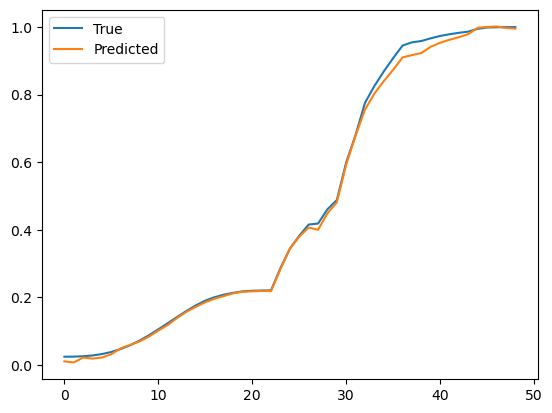

In [130]:
# class EchoStateNetwork:
#     def __init__(self, input_dim, reservoir_size, output_dim, spectral_radius=0.95, sparsity=0.1, input_scaling=1.0, regularization=1e-8):
#         self.input_dim = input_dim
#         self.reservoir_size = reservoir_size
#         self.output_dim = output_dim
#         self.spectral_radius = spectral_radius
#         self.sparsity = sparsity
#         self.input_scaling = input_scaling
#         self.regularization = regularization
        
#         # Initialize weights
#         self.Win = np.random.randn(reservoir_size, input_dim) * input_scaling
#         self.W = np.random.rand(reservoir_size, reservoir_size) - 0.5
#         self.W[np.random.rand(reservoir_size, reservoir_size) > sparsity] = 0
        
#         # Scale W to ensure the echo state property
#         radius = np.max(np.abs(np.linalg.eigvals(self.W)))
#         self.W *= spectral_radius / radius
        
#         self.Wout = None
    
#     def _update_state(self, x, prev_state):
#         return np.tanh(np.dot(self.Win, x) + np.dot(self.W, prev_state))
    
#     def fit(self, X, Y, washout=50):
#         N = X.shape[1]  # number of samples
#         state = np.zeros((self.reservoir_size, 1))
#         states = np.zeros((self.reservoir_size, N - washout))
        
#         # Drive the reservoir with the input
#         for t in range(N):
#             state = self._update_state(X[:, t].reshape(-1, 1), state)
#             if t >= washout:
#                 states[:, t - washout] = state.ravel()
        
#         # Train the readout using pseudo-inverse with regularization
#         states_T = states.T
#         self.Wout = np.dot(Y[:, washout:], np.dot(states_T, np.linalg.inv(np.dot(states, states_T) + self.regularization * np.identity(states.shape[0]))))
    
#     def predict(self, X, washout=50):
#         N = X.shape[1]
#         state = np.zeros((self.reservoir_size, 1))
#         outputs = np.zeros((self.output_dim, N - washout))
        
#         for t in range(N):
#             state = self._update_state(X[:, t].reshape(-1, 1), state)
#             if t >= washout:
#                 outputs[:, t - washout] = np.dot(self.Wout, state).ravel()
        
#         return outputs

# # Example usage
# np.random.seed(42)

# # Parameters
# input_dim = 3
# reservoir_size = 1000
# output_dim = 2

# num_training_sequences = 200
# num_test_sequences = 50

# X_train = train_x[0, :, :].T
# Y_train = train_y[0, :-1, :].T
# X_test = train_x[1, :, :].T
# Y_test = train_y[1, :-1, :].T

# X_train = train_x[:num_training_sequences, :, :].reshape(num_training_sequences*49, 3).T
# Y_train = train_y[:num_training_sequences, :-1, :].reshape(num_training_sequences*49, 2).T
# X_test = test_x[:num_test_sequences, :, :].reshape(num_test_sequences*49, 3).T
# Y_test = test_y[:num_test_sequences, :-1, :].reshape(num_test_sequences*49, 2).T
# print(X_train.shape)

# # Instantiate the ESN
# esn = EchoStateNetwork(input_dim, reservoir_size, output_dim, spectral_radius=0.9, sparsity=0.1)

# # Train the ESN
# esn.fit(X_train, Y_train, washout=0)

# # Make predictions
# Y_pred = esn.predict(X_test, washout=0)

# Plot the results
import matplotlib.pyplot as plt
X_test_reshape = X_test.reshape(3, 50, 49)
Y_test_reshape = Y_test.reshape(2, 50, 49)
Y_pred_reshape = Y_pred.reshape(2, 50, 49)
plt.plot(range(49), Y_test_reshape[0, 31, :].flatten(), label='True')
plt.plot(range(49), Y_pred_reshape[0, 31, :].flatten(), label='Predicted')
plt.legend()
plt.show()

Outputs are calculated as follows:

$$
\textbf{y}_{n+1} = \textbf{W}_{\text{out}} \cdot g(\textbf{W}_{\text{in}} \, \textbf{x}_{n+1} + \textbf{W}\, \textbf{h}_n)
$$

In [136]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["*", "+", "-", "/"],
    unary_operators=["square", "cube", "exp"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

X_pysr = X_test_reshape[:, 20:, :].reshape((3, 30*49)).T
Y_pysr = Y_test_reshape[:, 20:, :].reshape((2, 30*49)).T

model.fit(X_pysr, Y_pysr)

/home/ucaptp0/.conda/envs/ml-gcm-env/lib/python3.10/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/9q4ZC/src/Configure.jl:55
[ Info: Started!



Expressions evaluated per second: 4.610e+04
Head worker occupation: 5.1%
Progress: 99 / 1200 total iterations (8.250%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.425e-01  7.971e+00  y₀ = square(-0.68634)
3           3.494e-02  1.405e+00  y₀ = x₁ - x₀
4           1.123e-02  1.136e+00  y₀ = square(1.046 - x₀)
5           1.077e-02  4.127e-02  y₀ = square(square(x₂) - 1.046)
6           9.918e-03  8.259e-02  y₀ = square(square(x₂) - square(1.046))
7           6.518e-03  4.197e-01  y₀ = exp(0.044123) / cube(exp(cube(x₂)))
8           6.515e-03  4.389e-04  y₀ = exp(square(-0.19227)) / cube(exp(cube(x₂)))
10          6.223e-03  2.292e-02  y₀ = cube(exp(cube(cube(cube(x₁ - x₀)) - x₂)))
13          6.003e-03  1.203e-02  y₀ = cube(exp(cube((square(x₀ + -0.55055) / cube(exp(x₂))) - x...
                                  ₂)))
17          5.970

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                          0.4762493   
	1         0.000178                                 square(-0.6864354)   
	2         1.759934                                     0.9189026 - x0   
	3         0.959062                               cube(1.0718861 - x0)   
	4         0.122945                        cube(exp(0.061109778 - x0))   
	5   >>>>  0.243040                  cube(exp(0.012252124 - cube(x2)))   
	6         0.017374         square(square(exp(cube(0.06733521 - x2))))   
	7         0.006588  square(exp(cube(0.118282095 - (x2 * 1.3146707))))   
	8         0.055088  square(cube(exp(cube(0.10842213 - x2)))) + 0.0...   
	9         0.083171  square(exp(cube((0.24257874 - (x2 * 1.3710815)...   
	10        0.003732   cube(exp(cube(cube(square(x1 - x0)) - x2) / x1))   
	11        0.026024  1.8169171 / ((square(square(x2 + x2) + x0) * x...   
	12        0.011040  cube(exp(cube((((cube(x1) - x2) * (x2 - x0)) *...   
	13        0.011834  cube(exp(cube((((cube(x1) - x2) * (x2 - x0)) *...   
	14        0.111304  cube(exp(cube(((x2 + (x2 - cube(x0 + x0))) * (...   
	15        0.011992  cube(exp(cube(((x2 + (x2 - cube(x0 + square(x2...   
	16        0.014679  cube(exp(cube(((x2 + ((x2 - cube(x0 + x0)) * 1...   
	
	        loss  complexity  
	0   0.142507           1  
	1   0.142482           2  
	2   0.024515           3  
	3   0.009395           4  
	4   0.008308           5  
	5   0.006516           6  
	6   0.006404           7  
	7   0.006362           8  
	8   0.006021           9  
	9   0.005540          10  
	10  0.005499          12  
	11  0.005358          13  
	12  0.005241          15  
	13  0.005118          17  
	14  0.004579          18  
	15  0.004524          19  
	16  0.004458          20  
], [
	    pick     score                                           equation  \
	0         0.000000                                 square(-0.6236139)   
	1         2.507510                                      1.033568 - x2   
	2         0.411434                               exp(x0 * -3.1008875)   
	3         0.030941                        exp((-3.5791452 * x1) * x0)   
	4   >>>>  0.165295             exp(-3.0444145 * cube(x2)) * 0.8632787   
	5         0.073627    x1 / (0.9605845 + cube(square(x2) / 0.3725691))   
	6         0.001506  x1 / (0.9679097 + square(square((x2 + square(x...   
	7         0.001790  x1 / (0.9679097 + (square(square((x2 + square(...   
	8         0.012243  x1 / (0.9679097 + (square(cube((x2 / 1.2322495...   
	9         0.001797  x1 / (0.9679097 + square(((square(x2 + x2) + x...   
	10        0.002064  x1 / (cube(((x2 + (x0 + cube(cube(x0)))) + x2)...   
	11        0.029205  x1 / (cube(((x2 + (x0 + cube(cube(cube(x0)))))...   
	12        0.002069  x1 / (cube(((x2 + (x0 + cube(square(cube(x0)))...   
	
	        loss  complexity  
	0   0.097635           2  
	1   0.007954           3  
	2   0.005271           4  
	3   0.004955           6  
	4   0.004200           7  
	5   0.003625           9  
	6   0.003609          12  
	7   0.003596          14  
	8   0.003552          15  
	9   0.003539          17  
	10  0.003532          18  
	11  0.003430          19  
	12  0.003423          20  
]]

In [115]:
model.equations_[1]

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.418988,0.000000e+00,x2,x2,PySRFunction(X=>x2)
1,2,0.098296,1.449861e+00,square(-0.6332625),0.401021393906250,PySRFunction(X=>0.401021393906250)
2,3,0.007003,2.641699e+00,1.0447171 - x2,1.0447171 - x2,PySRFunction(X=>1.0447171 - x2)
3,4,0.003707,6.361669e-01,exp(-2.951564 * x0),exp(-2.951564*x0),PySRFunction(X=>exp(-2.951564*x0))
4,5,0.003673,9.052665e-03,cube(exp(0.004787052 - x0)),1.01446477282578*exp(-3*x0),PySRFunction(X=>1.01446477282578*exp(-3*x0))
5,6,0.002370,4.379980e-01,cube(exp(-0.042846553 - cube(x2))),0.879378686447522*exp(-3*x2**3),PySRFunction(X=>0.879378686447522*exp(-3*x2**3))
6,8,0.002288,1.770169e-02,cube(exp((-0.063724495 - cube(x2)) * x1)),exp(3*x1*(-x2**3 - 0.063724495)),PySRFunction(X=>exp(3*x1*(-x2**3 - 0.063724495)))
7,9,0.001926,1.721184e-01,cube(exp(-0.063724495 - square(square(x2) / x1))),0.825989278970494*exp(-3*x2**4/x1**2),PySRFunction(X=>0.825989278970494*exp(-3*x2**4...
8,10,0.001926,1.038320e-07,cube(exp(-0.063724495 - (square(square(x2)) / ...,0.825989278970494*exp(-3*x2**4/x1**2),PySRFunction(X=>0.825989278970494*exp(-3*x2**4...
9,11,0.001919,3.730157e-03,cube(exp(-0.063724495 - square((square(x2) + -...,0.825989278970494*exp(-3*(x2**2 - 0.0028129776...,PySRFunction(X=>0.825989278970494*exp(-3*(x2**...


## Prediction Errors

In [143]:
abs_errors = np.abs(ytest - ypred)
percentage_element_errors = 100 * abs_errors / ytest
column_errors = np.sum(abs_errors, axis=1)
scaling = np.sum(np.abs(ytest), axis=1)

percentage_errors = 100 * column_errors / scaling

In [144]:
mean_error_across_altitude_levels = np.mean(percentage_element_errors, axis=0)
std_error_across_altitude_levels = np.std(percentage_element_errors, axis=0)

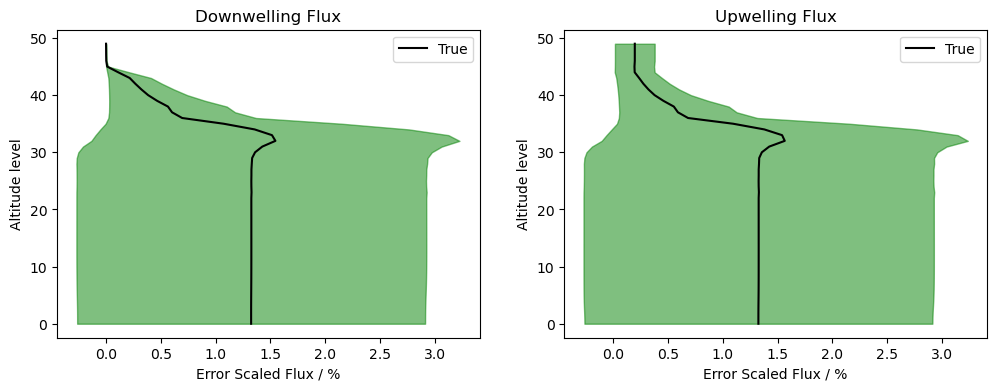

In [137]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)

axs[0].plot(mean_error_across_altitude_levels[:, 0], list(range(50)), color="k", label="True")
axs[0].set_title("Downwelling Flux")
axs[0].set_ylabel("Altitude level")
axs[0].set_xlabel("Error Scaled Flux / %")
axs[0].fill_betweenx(list(range(50)), mean_error_across_altitude_levels[:, 0] - std_error_across_altitude_levels[:, 0], mean_error_across_altitude_levels[:, 0] + std_error_across_altitude_levels[:, 0], color="g", alpha=0.5)
axs[0].legend()

axs[1].plot(mean_error_across_altitude_levels[:, 1], list(range(50)), color="k", label="True")
axs[1].set_title("Upwelling Flux")
axs[1].set_ylabel("Altitude level")
axs[1].set_xlabel("Error Scaled Flux / %")
axs[1].fill_betweenx(list(range(50)), mean_error_across_altitude_levels[:, 1] - std_error_across_altitude_levels[:, 1], mean_error_across_altitude_levels[:, 1] + std_error_across_altitude_levels[:, 1], color="g", alpha=0.5)
axs[1].legend()

plt.show()

In [145]:
print("percentage_errors shape: ", percentage_errors.shape)

print("Mean: ", np.mean(percentage_errors, axis=0))
print("Max: ", np.max(percentage_errors, axis=0))
print("ArgMax: ", np.argmax(percentage_errors, axis=0))
print("Min: ", np.min(percentage_errors, axis=0))


percentage_errors shape:  (768000, 2)
Mean:  [0.69515282 0.74038009]
Max:  [6.74633126 6.57016132]
ArgMax:  [61361 61361]
Min:  [0.00692986 0.00976726]


In [54]:
np.argsort(percentage_errors, axis=0)[int(percentage_errors.shape[0] * 0.5)]

array([276661, 546735])

In [52]:
print(np.mean(percentage_errors, axis=0))
print(np.std(percentage_errors, axis=0))

[0.74770001 0.79700015]
[0.66841994 0.66813215]


### Including aux variables

In [ ]:
num_train_samples = 1000

X = train_x[:num_train_samples, :, :].reshape(num_train_samples, 49 * 3)
aux_X = train_aux_x[:num_train_samples, :]
y = train_y[:num_train_samples, :, :].reshape(num_train_samples, 50 * 2)

input_size = (49 * 3) + 5
output_size = 50 * 2

new_X = np.zeros((num_train_samples, input_size))
new_X[:, :(49 * 3)] = X
new_X[:, (49 * 3):] = aux_X

X = new_X

hidden_size = 200

elm2 = ELM(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    activation_function="relu"
)

elm2.fit(X, y)

num_test_samples = 100000

Xtest = test_x[:, :, :].reshape(768000, 49 * 3)
aux_X = test_aux_x[:, :]
ytest = test_y[:, :, :]

new_Xtest = np.zeros((768000, input_size))
new_Xtest[:, :(49 * 3)] = Xtest
new_Xtest[:, (49 * 3):] = aux_X

Xtest = new_Xtest

ypred = elm2.predict(Xtest)
ypred = ypred.reshape(768000, 50, 2)

In [100]:
abs_errors = np.abs(ytest - ypred)
percentage_element_errors = 100 * abs_errors / ytest
column_errors = np.sum(abs_errors, axis=1)
scaling = np.sum(np.abs(ytest), axis=1)

percentage_errors = 100 * column_errors / scaling

print("percentage_errors shape: ", percentage_errors.shape)

print("Mean: ", np.mean(percentage_errors, axis=0))
print("Max: ", np.max(percentage_errors, axis=0))
print("ArgMax: ", np.argmax(percentage_errors, axis=0))
print("Min: ", np.min(percentage_errors, axis=0))

mean_error_across_altitude_levels = np.mean(percentage_element_errors, axis=0)
std_error_across_altitude_levels = np.std(percentage_element_errors, axis=0)

percentage_errors shape:  (768000, 2)
Mean:  [0.98568559 1.0841558 ]
Max:  [8.82022724 8.60210059]
ArgMax:  [341200 341200]
Min:  [0.01022514 0.01487451]


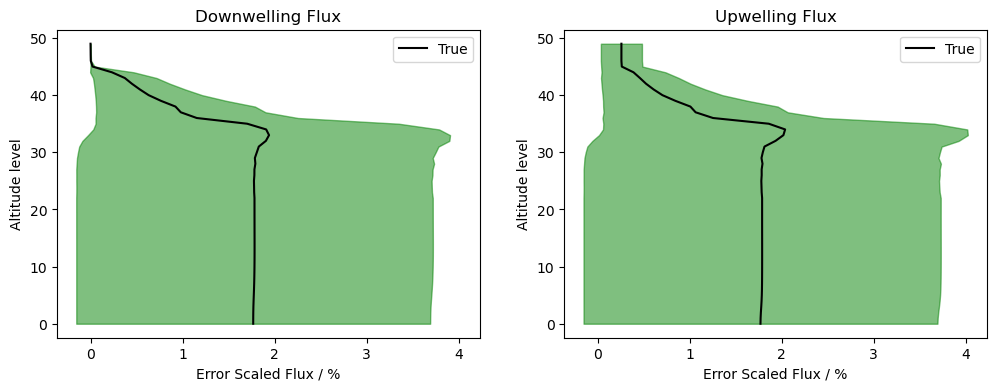

In [101]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)

axs[0].plot(mean_error_across_altitude_levels[:, 0], list(range(50)), color="k", label="True")
axs[0].set_title("Downwelling Flux")
axs[0].set_ylabel("Altitude level")
axs[0].set_xlabel("Error Scaled Flux / %")
axs[0].fill_betweenx(list(range(50)), mean_error_across_altitude_levels[:, 0] - std_error_across_altitude_levels[:, 0], mean_error_across_altitude_levels[:, 0] + std_error_across_altitude_levels[:, 0], color="g", alpha=0.5)
axs[0].legend()

axs[1].plot(mean_error_across_altitude_levels[:, 1], list(range(50)), color="k", label="True")
axs[1].set_title("Upwelling Flux")
axs[1].set_ylabel("Altitude level")
axs[1].set_xlabel("Error Scaled Flux / %")
axs[1].fill_betweenx(list(range(50)), mean_error_across_altitude_levels[:, 1] - std_error_across_altitude_levels[:, 1], mean_error_across_altitude_levels[:, 1] + std_error_across_altitude_levels[:, 1], color="g", alpha=0.5)
axs[1].legend()

plt.show()